pip install pytorch-gradcam

In [89]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import torch
import torchvision.transforms as transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image

from PIL import Image
import cv2
import numpy as np
import os


In [90]:
model_path = 'C:/Users/wfaiz/yolov5/runs/train/New folder/exp2/weights/best.pt'


In [91]:
# Load our custom trained model
model = torch.hub.load('ultralytics/yolov5', 'custom', model_path)
#model.eval()

Using cache found in C:\Users\wfaiz/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-31 Python-3.12.3 torch-2.3.0 CPU

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [92]:
# Evaluate which target layer to focus on. Choosing convolution layers closer to segmentation output.
for k, v in model.named_parameters():
    print(k)

model.model.model.0.conv.weight
model.model.model.0.conv.bias
model.model.model.1.conv.weight
model.model.model.1.conv.bias
model.model.model.2.cv1.conv.weight
model.model.model.2.cv1.conv.bias
model.model.model.2.cv2.conv.weight
model.model.model.2.cv2.conv.bias
model.model.model.2.cv3.conv.weight
model.model.model.2.cv3.conv.bias
model.model.model.2.m.0.cv1.conv.weight
model.model.model.2.m.0.cv1.conv.bias
model.model.model.2.m.0.cv2.conv.weight
model.model.model.2.m.0.cv2.conv.bias
model.model.model.3.conv.weight
model.model.model.3.conv.bias
model.model.model.4.cv1.conv.weight
model.model.model.4.cv1.conv.bias
model.model.model.4.cv2.conv.weight
model.model.model.4.cv2.conv.bias
model.model.model.4.cv3.conv.weight
model.model.model.4.cv3.conv.bias
model.model.model.4.m.0.cv1.conv.weight
model.model.model.4.m.0.cv1.conv.bias
model.model.model.4.m.0.cv2.conv.weight
model.model.model.4.m.0.cv2.conv.bias
model.model.model.4.m.1.cv1.conv.weight
model.model.model.4.m.1.cv1.conv.bias
mode

In [93]:
# Define the image path to test grad-cam
path = 'C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/'


In [94]:
# Loading and cropping image as per model input dimensions
def loading_image(path, image, crop_size):
    image_path = os.path.join(path, image)

    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    pad_height = crop_size[0] - h
    pad_width = crop_size[1] - w
    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad
    padded_image = cv2.copyMakeBorder(image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        
    return image, padded_image

In [95]:
img = "l_light_11_spur_02_5_600.jpg"

In [96]:
crop_size = (640 , 640)
image, padded_image = loading_image(path, img, crop_size)

In [97]:
# define colors for heat map

COLORS = np.random.uniform(0, 255, size=(80, 3))

In [98]:
def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.25:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


In [99]:
def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

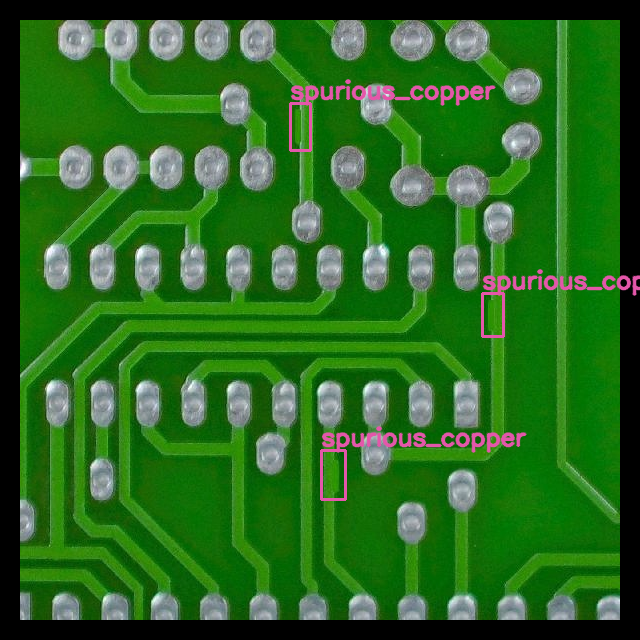

In [100]:
img = cv2.resize(padded_image, (640, 640)) #to ensure image size matches the model input
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

#model = torch.hub.load('ultralytics/yolov5', 'custom', model_path)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

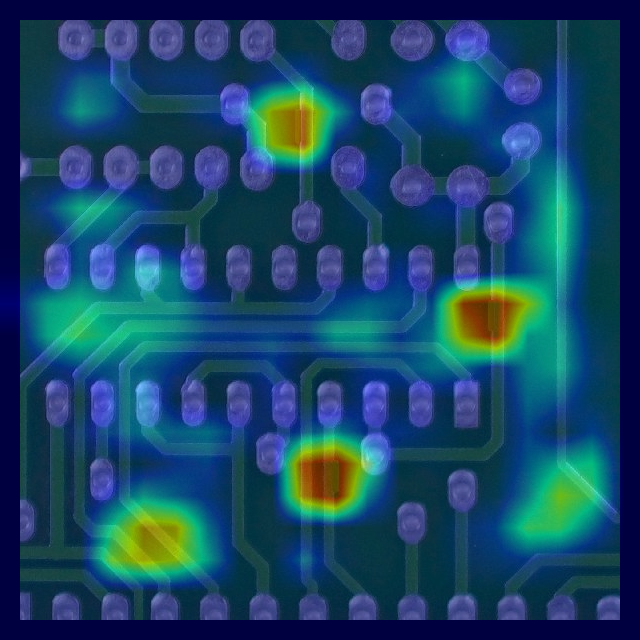

In [101]:
cam = EigenCAM(model, target_layers)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

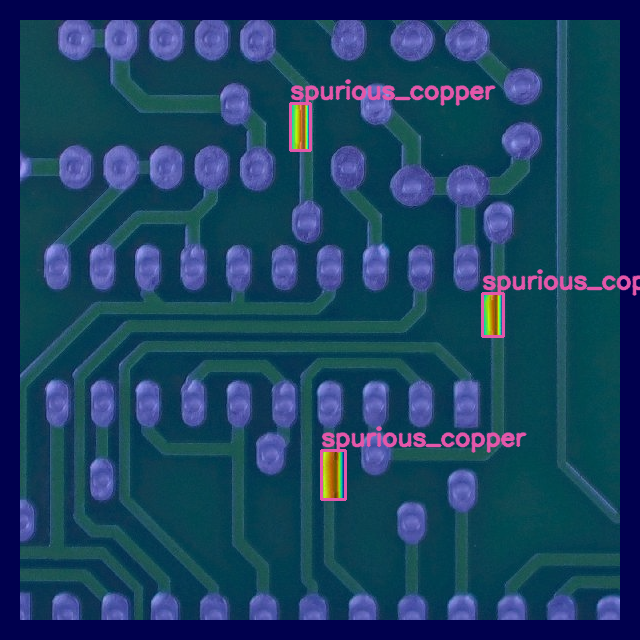

In [102]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)